In [2]:
import flopy
import geopandas as gpd
from scipy.interpolate import griddata
from osgeo import osr
import stat
import os

In [3]:
# create the spatial reference
srs = osr.SpatialReference()

# set the spatial reference from the WKT string
srs.ImportFromWkt('PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unknown_based_on_Krassovsky_1942_ellipsoid",SPHEROID["Krassovsky_1942",6378245.0,298.3]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",2250000.0],PARAMETER["False_Northing",-5714743.504],PARAMETER["Central_Meridian",44.55],PARAMETER["Scale_Factor",1.0],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')

# convert to PROJ string
proj_string = srs.ExportToProj4()

In [4]:
ws = "tests/novgorod"
model_name = "nn"
exe_name = os.path.join("bin", "mf6")
st = os.stat(exe_name)
os.chmod(exe_name, st.st_mode | stat.S_IEXEC)

sim = flopy.mf6.MFSimulation.load(sim_ws=ws, exe_name=exe_name)
m = sim.get_model(model_name)
modelgrid = m.modelgrid

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
    loading package drn...
    loading package obs...
    loading package oc...
  loading solution package nn...


In [47]:
drn = m.get_package("DRN")
drn_std = [[cond[0], cond[1], cond[2] * 100] for cond in drn.stress_period_data.array[0]]
m.remove_package("DRN")
drn = flopy.mf6.ModflowGwfdrn(
    m, print_input=True, print_flows=True, stress_period_data=drn_std
)

In [16]:
# Read the shapefiles
g = gpd.read_file(os.path.join(ws, "grid", "qtgrid.shp"))
flood_river_zone = gpd.read_file(os.path.join("novgorod", "input", "vectors", "zones_flood_chd.shp"))
intersections = gpd.sjoin(g, flood_river_zone, how="inner", op="intersects")
values = intersections['nodenumber'].values

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_963/809836069.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unk ...

  intersections = gpd.sjoin(g, flood_river_zone, how="inner", op="intersects")


[   455    457    458 ... 128974 128975 128976]


In [17]:
stvors = gpd.read_file(os.path.join("novgorod", "input", "vectors", "Stvor_all_1% 10%_new.shp"), crs=proj_string)

points_x = stvors.geometry.x.to_numpy()
points_y = stvors.geometry.y.to_numpy()
points_stage = stvors["1%"].to_numpy()

cell2d = m.disv.cell2d.get_data()
centroids_x = [cell[1] for cell in cell2d]
centroids_y = [cell[2] for cell in cell2d]

# Interpolate

interpolated_stages = griddata((points_x, points_y), points_stage, (centroids_x, centroids_y), method='nearest')

In [18]:
import numpy as np
stage = np.where(interpolated_stages - modelgrid.botm[0] <= 0, modelgrid.botm[0] + 0.1, interpolated_stages)
flood_cells = np.array(values)
chd_flood = [[(0, cell), stage[cell]]  for cell in flood_cells]

In [19]:
tdis = sim.get_package("tdis")
tdis.perioddata = [(1, 1, 1.0), (30, 6, 1.0)]
tdis.nper = 2

In [20]:
# storage package
sy = flopy.mf6.ModflowGwfsto.sy.empty(m, layered=True)
sy["data"] = 0.2

ss = flopy.mf6.ModflowGwfsto.ss.empty(
    m, layered=True, default_value=0.00009
)

sto = flopy.mf6.ModflowGwfsto(
    m,
    pname="sto",
    save_flows=True,
    iconvert=1,
    ss=ss,
    sy=sy,
    steady_state={0: True},
    transient={1: True},
)

In [21]:
riv = m.get_package("riv_0")
riv.stress_period_data = {0: riv.stress_period_data.array[0], 1: [()]}

In [22]:
chd = flopy.mf6.ModflowGwfchd(m, stress_period_data={1: chd_flood})

In [23]:
rch = m.get_package("RCH")
rch.recharge = {0: rch.recharge.array[0], 1: rch.recharge.array[0]}

In [30]:
npf = m.get_package("NPF")
npf.k = npf.k.array

In [24]:
# Write the datasets
sim.set_all_data_external(True)
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package nn...
  writing model nn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package riv_0...
    writing package rch...
    writing package drn_0...
    writing package obs_0...
    writing package oc...
    writing package wel...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 79669 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications r

<a list of 38 text.Text objects>

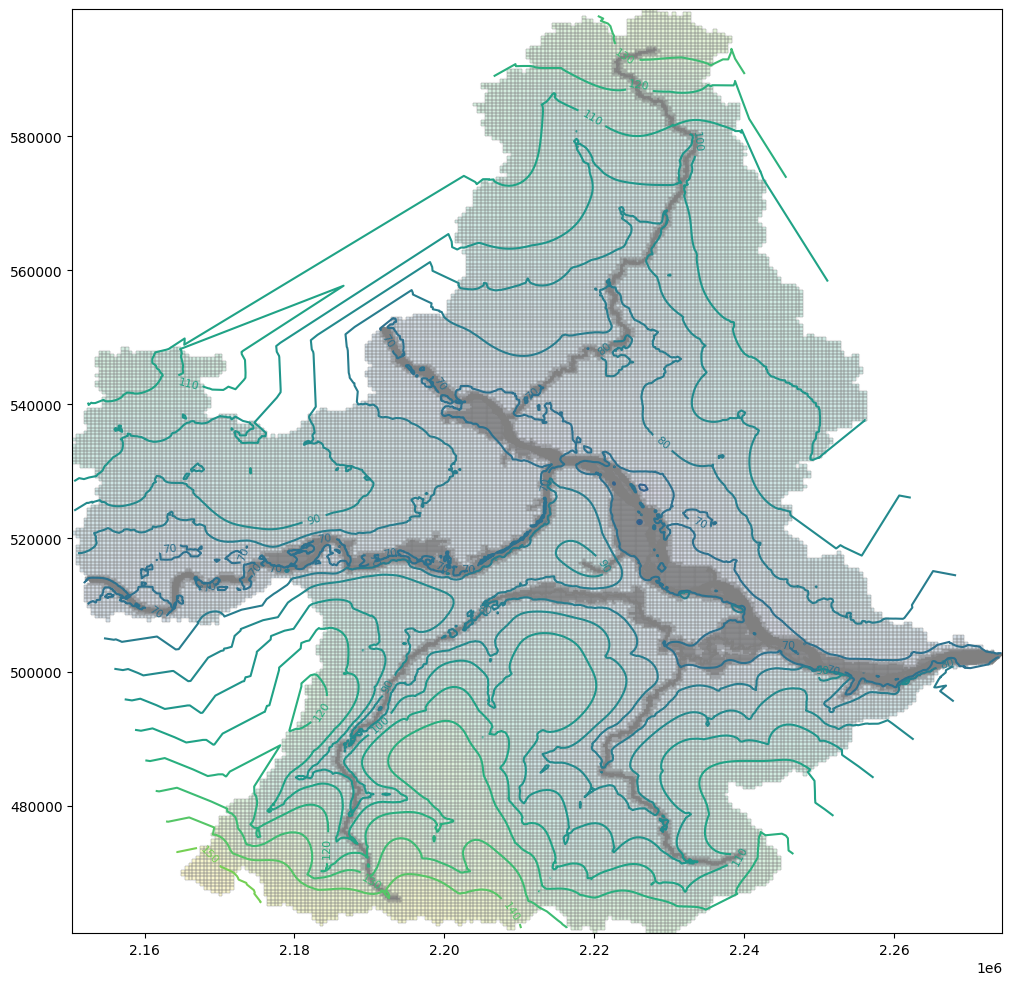

In [6]:
import matplotlib.pyplot as plt
import numpy as np
headfile = f"{model_name}.hds"
fname = os.path.join(ws, headfile)
hds = flopy.utils.HeadFile(fname)
# head1 = hds.get_data(kstpkper=(5, 1))
head2 = hds.get_data(kstpkper=(0, 0))
# head_change = modelgrid.top - head1
# head_dif = head1 - head2
# levels = np.arange(0, 200, 10)
levels = np.arange(0, 200, 10)
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_array(head2, alpha=0.2)
pmv.plot_grid(alpha=0.2)
contour = pmv.contour_array(head2, levels=levels)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

In [22]:
flopy.export.utils.export_array(modelgrid, 'top.shp', modelgrid.top)

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


In [23]:
from flopy.utils import Raster
raster_ws = os.path.join("novgorod", "input", "rasters")
# dem_name = "fabdem.tif"
dem_name = "Relief_new"

rio = Raster.load(os.path.join(raster_ws, dem_name))
arr = rio.get_array(1)
idx = np.isfinite(arr)
vmin, vmax = arr[idx].min(), arr[idx].max()

In [24]:
dem_data = rio.resample_to_grid(
    modelgrid, band=rio.bands[0], method="nearest"
)
head_change = dem_data - head1

In [27]:
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

boundary = gpd.read_file('novgorod/input/vectors/boundary.shp', crs=proj_string)
CRS = boundary.crs
bounds = boundary.bounds
head_change_rast = np.where(head_change <= 0.1, 0.1, head_change)
head_change_rast = np.where((head_change_rast > 0.1) & (head_change_rast<=0.7), 0.7, head_change_rast)
head_change_rast = np.where((head_change_rast > 0.7) & (head_change_rast<=1.2), 1.2, head_change_rast)
head_change_rast = np.where((head_change_rast > 1.2) & (head_change_rast<=2), 2, head_change_rast)
head_change_rast = np.where((head_change_rast > 2) & (head_change_rast<=3.2), 3.2, head_change_rast)
head_change_rast = np.where(head_change_rast > 3.2, 4, head_change_rast)
print(np.unique(head_change_rast))
range_x = bounds.maxx[0] - bounds.minx[0]
range_y = bounds.maxy[0] - bounds.miny[0]

# Calculate the number of cells for a grid cell size of 50m
num_cells_x = int(range_x / 50) 
num_cells_y = int(range_y / 50)

cell2d = m.disv.cell2d.get_data()
centroids_x = [cell[1] for cell in cell2d]
centroids_y = [cell[2] for cell in cell2d]

# Define grid_x and grid_y
gridx, gridy = np.meshgrid(np.linspace(bounds.minx[0], bounds.maxx[0], num=num_cells_x),
                           np.linspace(bounds.miny[0], bounds.maxy[0], num=num_cells_y))
transform = from_origin(gridx.min(), gridy.max(), 50, 50)
# Original coordinates
original_coords = np.array([centroids_x, centroids_y]).T  # x_coordinates and y_coordinates should be 1D arrays containing the x and y coordinates of your original data points respectively.

# Interpolate data
interpolated_data = griddata(original_coords, head_change_rast.flatten(), (gridx, gridy), method='linear')  # 'nearest', 'linear', or 'cubic' interpolation methods can be used depending on the data.

# Now use interpolated_data with rasterio
new_dataset = rasterio.open(
    "flood_zones4.tif",
    'w',
    driver='GTiff',
    height=interpolated_data.shape[0],
    width=interpolated_data.shape[1],
    count=1,
    dtype=str(interpolated_data.dtype),
    nodata=np.nan,
    crs=CRS,
    transform=transform,
)
new_dataset.write(interpolated_data[::-1], 1)
new_dataset.close()

[0.1 0.7 1.2 2.  3.2 4. ]


In [32]:
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
boundary = gpd.read_file('novgorod/input/vectors/boundary.shp', crs=proj_string)
CRS = boundary.crs
bounds = boundary.bounds
range_x = bounds.maxx[0] - bounds.minx[0]
range_y = bounds.maxy[0] - bounds.miny[0]
num_cells_x = int(range_x / 500)
num_cells_y = int(range_y / 500)

cell2d = m.disv.cell2d.get_data()
centroids_x = [cell[1] for cell in cell2d]
centroids_y = [cell[2] for cell in cell2d]

# Define grid_x and grid_y
gridx, gridy = np.meshgrid(np.linspace(bounds.minx[0], bounds.maxx[0], num=num_cells_x),
                           np.linspace(bounds.miny[0], bounds.maxy[0], num=num_cells_y))
transform = from_origin(gridx.min(), gridy.max(), 500, 500)
# Original coordinates
original_coords = np.array([centroids_x, centroids_y]).T  # x_coordinates and y_coordinates should be 1D arrays containing the x and y coordinates of your original data points respectively.

# Interpolate data
interpolated_data = griddata(original_coords, rch.recharge.array[0], (gridx, gridy), method='linear')  # 'nearest', 'linear', or 'cubic' interpolation methods can be used depending on the data.

# Now use interpolated_data with rasterio
new_dataset = rasterio.open(
    "rch.tif",
    'w',
    driver='GTiff',
    height=interpolated_data.shape[0],
    width=interpolated_data.shape[1],
    count=1,
    dtype=str(interpolated_data.dtype),
    nodata=np.nan,
    crs=CRS,
    transform=transform,
)
new_dataset.write(interpolated_data[::-1], 1)
new_dataset.close()

ValueError: different number of values and points

In [29]:
riv = m.get_package("riv_0")

In [36]:
riv.stress_period_data.array[0]["cond"] = riv.stress_period_data.array[0]["cond"]*100

In [20]:
print(max(npf.k.array[0]))

50.0
